In [ ]:
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [2]:
import random

def set_random_seed(seed_value):
    """Set the random seed for reproducibility."""
    random.seed(seed_value)  # Set the seed for Python's random module
    np.random.seed(seed_value)  # Set the seed for NumPy
    torch.manual_seed(seed_value)  # Set the seed for PyTorch CPU
    torch.cuda.manual_seed(seed_value)  # Set the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)  # Set the seed for all GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on GPU
    torch.backends.cudnn.benchmark = False  # Turn off benchmarks for reproducibility

# Set a specific random seed value (e.g., 42)
set_random_seed(42)

In [3]:
# Load the data
def load_data():
    reviews = pd.read_pickle('../Pickle/reviews.pkl')
    books = pd.read_pickle('../Pickle/books.pkl')
    read = pd.read_pickle('../Pickle/read.pkl')
    user_genres = pd.read_pickle('../Pickle/user_most_common_genres.pkl')
    review_embeddings = pd.read_pickle('../Pickle/review_embeddings.pkl')
    review_sentiment = pd.read_pickle('../Pickle/review_score.pkl')
    imputed = pd.read_pickle('../Pickle/imputed_ratings.pkl')
    return reviews, books, read, user_genres, review_embeddings, review_sentiment, imputed

In [ ]:
def split_data(ratings_data, user_genres, test_size=0.1, val_size=0.15, random_state=42):
    # Merge the ratings_data and user_genres on user_id to get the most common genres for users
    merged_data = ratings_data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')

    # Identify users and books that appear only once in the dataset
    user_counts = merged_data['user_id'].value_counts()
    book_counts = merged_data['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = merged_data[
        merged_data['user_id'].isin(user_counts[user_counts == 1].index) | 
        merged_data['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = merged_data[~merged_data.index.isin(single_interactions.index)]

    # Split the remaining interactions into train, validation, and test
    train_df, temp_data = train_test_split(remaining_interactions, test_size=test_size+val_size, random_state=random_state)
    val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size+val_size), random_state=random_state)

    # Add the single interactions to the training set
    train_data = pd.concat([train_df, single_interactions], ignore_index=True)

    return train_data, val_data, test_data

In [ ]:
# Initialize ID mappings for users and books
def initialize_id_mappings(combined_data):
    unique_user_ids = set(combined_data['user_id'])
    unique_book_ids = set(combined_data['book_id'])
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
    book_id_to_index = {book_id: idx for idx, book_id in enumerate(unique_book_ids)}
    return user_id_to_index, book_id_to_index

In [ ]:
def balance_ratings(df, target_column='rating', target_count=12000):
    balanced_data = []
    
    for rating in df[target_column].unique():
        class_data = df[df[target_column] == rating]
        original_data = class_data.copy()  # Preserve original ratings
        
        if len(class_data) < target_count:
            # Oversample
            class_data_resampled = resample(class_data, replace=True, n_samples=target_count, random_state=42)
            
            # Identify new duplicate rows (not in original data)
            duplicated_mask = class_data_resampled.index.isin(original_data.index)
            
            # Modify only the new duplicate ratings
            class_data_resampled.loc[~duplicated_mask, target_column] += np.random.uniform(-0.3, 0.3, size=sum(~duplicated_mask))
        else:
            # Under-sample
            class_data_resampled = resample(class_data, replace=False, n_samples=target_count, random_state=42)
        
        balanced_data.append(class_data_resampled)
    
    # Combine and shuffle
    balanced_df = pd.concat(balanced_data, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

In [ ]:
# Log scale ratings
def normalise_ratings(train_data, test_data, val_data):
    min_rating = train_data['rating'].min()
    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])
    val_data['rating'] = np.log1p(val_data['rating'])


    return train_data, test_data, val_data, min_rating

def denormalize_rating(log_scaled_ratings, min_rating):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)  # Ensure NumPy array
    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)
    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating
    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [ ]:
def user_book_features(filtered_data, user_id_to_index, book_id_to_index):
    # Combine user and book genres to create a unified genre list
    unique_genres = sorted(set(filtered_data['filtered_genres'].str.split(',').explode()).union(
        set(filtered_data['most_common_genres'].explode())
    ))
    
    # Create a common genre dictionary
    genre_dict = {genre: idx for idx, genre in enumerate(unique_genres)}
    # Prepare user genre features
    user_genre_features = {}
    # Group by user_id and process all genres at once
    for user_id, group in filtered_data.groupby('user_id'):
        genres = group['most_common_genres'].iloc[0]  # All rows for this user should have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        user_genre_features[user_id_to_index[user_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    # Prepare book genre features
    book_genre_features = {}
    for book_id, group in filtered_data.groupby('book_id'):
        genres = group['filtered_genres'].iloc[0].split(',')  # Assuming all rows for this book have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        book_genre_features[book_id_to_index[book_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    return user_genre_features, book_genre_features


In [9]:
def prepare_edge_index_ratings_attributes(df, user_id_to_index, book_id_to_index):
    # Map user and book IDs to indices
    user_indices = df['user_id'].map(user_id_to_index).dropna().astype(int).values
    book_indices = df['book_id'].map(book_id_to_index).dropna().astype(int).values

    # Ensure valid mappings
    valid_mask = (user_indices >= 0) & (book_indices >= 0)
    user_indices = user_indices[valid_mask]
    book_indices = book_indices[valid_mask]

    # Create edge index
    edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)

    # Convert ratings and confidence scores to tensors
    ratings_tensor = torch.tensor(df.loc[valid_mask, 'rating'].values, dtype=torch.float32).view(-1, 1)
    confidence_tensor = torch.tensor(df.loc[valid_mask, 'confidence_score'].values, dtype=torch.float32).view(-1, 1)

    # Efficiently convert list of NumPy arrays to a tensor
    embeddings_np = np.stack(df.loc[valid_mask, 'embeddings'].values)  # Stack directly
    embeddings_tensor = torch.from_numpy(embeddings_np).float()  # Convert efficiently

    # Concatenate ratings, confidence scores, and embeddings into a single edge attribute tensor
    edge_attr = torch.cat([ratings_tensor, confidence_tensor, embeddings_tensor], dim=1)

    return edge_index, edge_attr


In [10]:
def prepare_data_objects(train_data, val_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index):
    train_edge_index, train_edge_attr = prepare_edge_index_ratings_attributes(
        train_data, user_id_to_index, book_id_to_index
    )
    val_edge_index, val_edge_attr = prepare_edge_index_ratings_attributes(
        val_data, user_id_to_index, book_id_to_index
    )
    test_edge_index, test_edge_attr = prepare_edge_index_ratings_attributes(
        test_data, user_id_to_index, book_id_to_index
    )

    # Convert user and book genre features efficiently
    user_embeddings = torch.from_numpy(np.stack(list(user_genre_features.values()))).float()
    book_embeddings = torch.from_numpy(np.stack(list(book_genre_features.values()))).float()

    # Combine user and book embeddings into node features
    node_embeddings = torch.cat([user_embeddings, book_embeddings], dim=0)

    # Ensure edge_index is correctly formatted
    train_edge_index = train_edge_index.clone().detach()  # Ensure it's a tensor
    val_edge_index = val_edge_index.clone().detach()
    test_edge_index = test_edge_index.clone().detach()

    # Create PyG Data objects
    train_data_obj = Data(
        x=node_embeddings,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr  
    )

    val_data_obj = Data(
        x=node_embeddings,
        edge_index=val_edge_index,
        edge_attr=val_edge_attr
    )
    
    test_data_obj = Data(
        x=node_embeddings,
        edge_index=test_edge_index,
        edge_attr=test_edge_attr
    )

    return train_data_obj, val_data_obj, test_data_obj


In [11]:
reviews, books, read, user_genres, review_embeddings, review_sentiment, imputed= load_data()
reviews = reviews[reviews['rating'] != 0]

In [12]:
merged_df = pd.merge(reviews, imputed[['user_id', 'book_id', 'rating']], on=['user_id', 'book_id'], how='left', suffixes=('', '_new'))
merged_df['rating'] = merged_df['rating_new'].fillna(merged_df['rating'])  # Fill missing ratings
final_df = merged_df.drop(columns=['rating_new'])  # Drop the 'rating_new' column
reviews = final_df  # Update the original reviews DataFrame

In [ ]:
reviews = pd.merge(reviews, review_embeddings, on="review_id", how="inner")  

In [14]:
reviews = pd.merge(reviews, review_sentiment, on="review_id", how="inner") 

In [15]:
reviews  = reviews[['rating', 'user_id', 'book_id', 'confidence_score', 'embeddings']]   
books = books[['book_id', 'title', 'authors', 'filtered_genres', 'average_rating']]
data = pd.merge(books, reviews, on='book_id', how='inner')

In [16]:
data = data.reset_index(drop=True)
user_genres = user_genres.reset_index()
user_genres = user_genres[user_genres['most_common_genres'].apply(lambda x: len(x) > 0)]

In [17]:
data = pd.merge(data, user_genres, on='user_id', how='inner')

In [18]:
train_data, val_data, test_data = split_data(data, user_genres)

In [19]:
user_id_to_index, book_id_to_index = initialize_id_mappings(data)
train_data = balance_ratings(train_data)
train_data, test_data, val_data, min_rating = normalise_ratings(train_data, test_data, val_data)
user_genre_features, book_genre_features = user_book_features(data, user_id_to_index, book_id_to_index)
train_data_obj, val_data_obj, test_data_obj = prepare_data_objects(
    train_data, val_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index
)

C:\Users\maddy\AppData\Local\Temp\ipykernel_16240\2109782430.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)


In [20]:
import pickle
with open('../Pickle/user_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(user_id_to_index, f)

with open('../Pickle/book_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(book_id_to_index, f)

In [ ]:
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, edge_feature_dim, dropout_rate=0.1):
        super(GATModel, self).__init__()
        self.dropout_rate = dropout_rate  # Dropout rate

        # Define the GAT layers
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat4 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat5 = GATv2Conv(hidden_channels * num_heads, out_channels, heads=num_heads, concat=False, edge_dim=edge_feature_dim)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn2 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn3 = nn.BatchNorm1d(hidden_channels * num_heads)
        self.bn4 = nn.BatchNorm1d(hidden_channels * num_heads)

        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x, edge_index, edge_attr):
        x = self.gat1(x, edge_index, edge_attr)
        x = self.bn1(x)  # Batch Normalization
        x = F.elu(x)  # Activation function
        x = self.dropout(x)  # Dropout after activation

        x = self.gat2(x, edge_index, edge_attr)
        x = self.bn2(x)  
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index, edge_attr)
        x = self.bn3(x) 
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat4(x, edge_index, edge_attr)
        x = self.bn4(x)  
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat5(x, edge_index, edge_attr)  

       
        edge_outputs = torch.sum(x[edge_index[0]] * x[edge_index[1]], dim=-1)  # Index nodes by edge indices

        return edge_outputs, x


    def predict(self, x, edge_index, edge_attr):
        self.eval()  
        with torch.no_grad():  
            edge_outputs, node_embeddings = self.forward(x, edge_index, edge_attr)
            return node_embeddings, edge_outputs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_list = [train_data_obj]  
test_data_list = [test_data_obj]
val_data_list = [val_data_obj]

train_loader = DataLoader(train_data_list, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=8, shuffle=False)
val_loader = DataLoader(val_data_list, batch_size=8, shuffle=False)

all_embeddings = train_data['embeddings'].tolist() + test_data['embeddings'].tolist()

all_embeddings = np.array(all_embeddings, dtype=object)

embedding_size = len(all_embeddings[0])
edge_feature_dim = 1 + 1 + embedding_size  # Rating + Confidence + Embedding Size

model = GATModel(
    in_channels=train_data_obj.x.shape[1],  # Input features per node
    hidden_channels=35,
    out_channels=1,
    num_heads=30,
    edge_feature_dim=edge_feature_dim  # Correct edge feature dimension
).to(device) 

In [23]:
def plot_predictions(predictions, true_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.5, color='blue', label="Predictions vs True")
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Perfect Prediction')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Predicted Ratings vs True Ratings')
    plt.legend()
    plt.show()

In [24]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Test Loss')
    plt.show()

In [27]:
def train_gat(model, train_loader, val_loader, test_loader, num_epochs, lr, device):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Learning rate scheduler
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=10, delta=0.0001)

    all_true_values = []
    all_predicted_values = []
    train_losses = []
    val_losses = []
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        num_train_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            edge_outputs, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            edge_outputs = edge_outputs.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)

            all_true_values.extend(target.cpu().numpy())
            all_predicted_values.extend(edge_outputs.cpu().detach().numpy())

            loss = criterion(edge_outputs, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_train_batches += 1

        average_train_loss = total_train_loss / num_train_batches
        train_losses.append(average_train_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')

        model.eval()
        total_val_loss = 0
        num_val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                val_out, _ = model(batch.x, batch.edge_index, batch.edge_attr)
                val_out = val_out.view(-1, 1)
                target = batch.edge_attr[:, 0].view(-1, 1)
                val_loss = criterion(val_out, target)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        average_val_loss = total_val_loss / num_val_batches
        val_losses.append(average_val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}')

        if average_val_loss < early_stopping.best_loss:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1
            torch.save(best_model_state, '../Pickle/gat_model.pth')

        early_stopping(average_val_loss, epoch + 1)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}. Best model was at epoch {best_epoch}.")
            break

        scheduler.step()  # Update learning rate

    plot_loss(train_losses, val_losses)
    model.load_state_dict(torch.load('../Pickle/gat_model.pth'))
    print(f"Loaded best model from epoch {best_epoch} for final evaluation.")

    # Evaluation phase using the test set
    model.eval()
    all_preds = []
    all_true = []
    all_embeddings = [] 
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            test_out, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            test_out = test_out.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)
            all_preds.append(test_out)
            all_true.append(target)
            all_embeddings.append(embeddings.cpu().numpy())

    all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
    all_true = torch.cat(all_true, dim=0).cpu().numpy()
    all_embeddings = np.concatenate(all_embeddings, axis=0)

    rmse = root_mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    print(f"Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    return rmse, mae, all_embeddings

Epoch 1/150, Training Loss: 0.4017
Epoch 1/150, Validation Loss: 0.3087
Epoch 2/150, Training Loss: 0.2420
Epoch 2/150, Validation Loss: 0.4640
Epoch 3/150, Training Loss: 0.3969
Epoch 3/150, Validation Loss: 0.3315
Epoch 4/150, Training Loss: 0.2689
Epoch 4/150, Validation Loss: 0.6601
Epoch 5/150, Training Loss: 0.3431
Epoch 5/150, Validation Loss: 0.3804
Epoch 6/150, Training Loss: 0.2589
Epoch 6/150, Validation Loss: 0.0911
Epoch 7/150, Training Loss: 0.1801
Epoch 7/150, Validation Loss: 0.2828
Epoch 8/150, Training Loss: 0.2300
Epoch 8/150, Validation Loss: 0.3784
Epoch 9/150, Training Loss: 0.2491
Epoch 9/150, Validation Loss: 0.1878
Epoch 10/150, Training Loss: 0.2078
Epoch 10/150, Validation Loss: 0.1228
Epoch 11/150, Training Loss: 0.2007
Epoch 11/150, Validation Loss: 0.1720
Epoch 12/150, Training Loss: 0.2248
Epoch 12/150, Validation Loss: 0.1616
Epoch 13/150, Training Loss: 0.2184
Epoch 13/150, Validation Loss: 0.0980
Epoch 14/150, Training Loss: 0.1850
Epoch 14/150, Valida

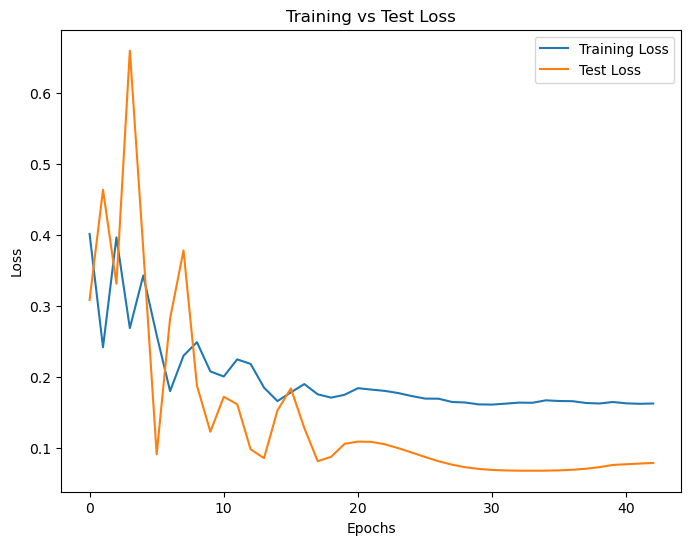

Loaded best model from epoch 34 for final evaluation.
Mean Squared Error: 0.2622
Mean Absolute Error: 0.1993


In [28]:
rmse, mae, all_embeddings = train_gat(model, train_loader, val_loader, test_loader, num_epochs=150, lr=0.0001, device=device)
node_embeddings, predicted_ratings = model.predict(test_data_obj.x, test_data_obj.edge_index, test_data_obj.edge_attr)

In [29]:
user_ids = test_data_obj.edge_index[0]  
item_ids = test_data_obj.edge_index[1]  
true_ratings = test_data_obj.edge_attr[:, 0].cpu().numpy()

# Modify predictions to include true ratings
predictions = [(uid.item(), iid.item(), true_ratings[idx], predicted_ratings[idx].item()) 
               for idx, (uid, iid) in enumerate(zip(user_ids, item_ids))]


In [30]:
with open('../Pickle/gat_embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)

In [ ]:
def evaluate_model(predictions, min_rating, k, threshold, item_popularity, num_users):
    # Denormalize predictions
    denormalized_predictions = [
        (uid, iid, true_r * (5 - min_rating) + min_rating, est * (5 - min_rating) + min_rating)
        for (uid, iid, true_r, est) in predictions
    ]

    user_est_true = defaultdict(list)
    for uid, iid, true_r, est in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []
    ndcgs = []
    map_scores = []
    mrr_scores = []  # MRR scores list
    novelty_scores = []
    hit_rate_scores = []
    all_recommended_items = set()           # For catalog coverage
    recommended_relevant_items = set()      # For relevant item coverage

    relevant_items = set(iid for _, iid, true_r, _ in denormalized_predictions if true_r >= threshold)

    for user_id, user_ratings in user_est_true.items():
        # Sort predictions by estimated value
        user_ratings_sorted = sorted(user_ratings, key=lambda x: x[1], reverse=True)
        top_k = user_ratings_sorted[:k]

        top_k_items = [iid for iid, _, _ in top_k]
        all_recommended_items.update(top_k_items)

        # Precision and Recall
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)

        precision = n_rel_and_rec_k / k if k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        # NDCG@k
        dcg = sum(
            (true_r >= threshold) / np.log2(idx + 2)
            for idx, (_, _, true_r) in enumerate(top_k)
        )
        idcg = sum(
            1.0 / np.log2(idx + 2) for idx in range(min(n_rel, k))
        )
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)

        # MAP@k
        hits = 0
        sum_precisions = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                hits += 1
                sum_precisions += hits / (idx + 1)
        ap = sum_precisions / min(n_rel, k) if n_rel != 0 else 0
        map_scores.append(ap)

        # MRR@k
        # Calculate MRR by using the reciprocal rank of the first relevant item
        mrr = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                mrr = 1 / (idx + 1)
                break
        mrr_scores.append(mrr)

        # Novelty (1 - average popularity of the recommended items)
        novelty = np.mean([1 - (item_popularity.get(iid, 1) / num_users) for iid in top_k_items])
        novelty_scores.append(novelty)

        # Hit Rate (proportion of users who have at least one relevant item in top_k)
        hit_rate = 1 if n_rel_and_rec_k > 0 else 0
        hit_rate_scores.append(hit_rate)

        # For Relevant Item Coverage@k
        recommended_relevant_items.update([iid for iid, est, true_r in top_k if true_r >= threshold])

    # Catalog Coverage@k
    catalog_coverage = len(all_recommended_items) / len(item_popularity) if item_popularity else 0

    # User Coverage@k (the proportion of users with at least one relevant recommendation)
    user_coverage = sum(1 for user_ratings in user_est_true.values() if any(true_r >= threshold for _, _, true_r in user_ratings)) / len(user_est_true)

    # Return results, now including mrr_scores
    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(map_scores),
        np.mean(mrr_scores),  
        np.mean(novelty_scores),
        np.mean(hit_rate_scores),
        user_coverage
    )

k = 5
threshold = 4  # Relevance threshold
item_popularity = test_data['book_id'].value_counts().to_dict()
num_users = test_data['user_id'].nunique()

# Compute metrics
precision, recall, ndcg, map_score, mrr, novelty, hit_rate, user_coverage = evaluate_model(
    predictions, min_rating=1.0, k=k, threshold=threshold, item_popularity=item_popularity, num_users=num_users
)

# Print results
print(f'Precision@{k}: {precision:.4f}')
print(f'Recall@{k}: {recall:.4f}')
print(f'nDCG@{k}: {ndcg:.4f}')
print(f'MAP@{k}: {map_score:.4f}')
print(f'MRR@{k}: {mrr:.4f}')
print(f'Novelty: {novelty:.4f}')
print(f'Hit Rate: {hit_rate:.4f}')
print(f'User Coverage: {user_coverage:.4f}')


Precision@5: 0.3438
Recall@5: 0.9650
nDCG@5: 0.9747
MAP@5: 0.9726
MRR@5: 0.9740
Novelty: 0.9996
Hit Rate: 0.9794
User Coverage: 0.9794


In [ ]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(predicted_ratings)

In [ ]:
predicted_ratings.min().item()

In [ ]:
predicted_ratings.max().item()

In [ ]:
predicted_ratings.mean()

In [ ]:
data['rating'].mean()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def visualize_embeddings_with_clustering(data_obj, embed_type="node", n_clusters=6):
    if embed_type == "node":
        embeddings = data_obj.x.cpu().detach().numpy()
        title = "PCA of Node Embeddings with Clusters"
    else:
        embeddings = data_obj.edge_attr.cpu().detach().numpy()
        title = "t-SNE of Edge Embeddings with Clusters"

    if embeddings.shape[1] > 2:  # Apply dimensionality reduction if needed
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    else:
        reduced_embeddings = embeddings

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings)
    labels = kmeans.labels_

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.colorbar(label="Cluster")
    plt.show()

In [ ]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="edge")

In [ ]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="node")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_node_embeddings(user_genre_features, book_genre_features):
    # Convert user and book genre features into numpy arrays
    all_user_features = torch.stack(list(user_genre_features.values())).cpu().numpy()
    all_book_features = torch.stack(list(book_genre_features.values())).cpu().numpy()

    # Combine user and book features for dimensionality reduction
    all_features = np.concatenate([all_user_features, all_book_features], axis=0)

    # Option 1: Use PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_features_pca = pca.fit_transform(all_features)

    # Option 2: Use t-SNE for dimensionality reduction (can capture nonlinear relationships)
    tsne = TSNE(n_components=2)
    reduced_features_tsne = tsne.fit_transform(all_features)

    # Plot PCA reduced features
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], c='blue', label='Embeddings')
    plt.title("2D Projection of User and Book Features (PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

    # Plot t-SNE reduced features
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c='red', label='Embeddings')
    plt.title("2D Projection of User and Book Features (t-SNE)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

In [ ]:
plot_node_embeddings(user_genre_features, book_genre_features)

In [ ]:
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(train_data['rating'], bins=5)
plt.title('Distribution of Ratings In GATv2Conv Train Data')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()
import matplotlib.pyplot as plt


# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist(test_data['rating'], bins=5)
plt.title('Distribution of Ratings In GATv2Conv Test Data')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()